# 필요 패키지 설치

In [23]:
# dbf 파일 관련 패키지
!pip install dbfread

# 지리공간용 pandas 확장 툴
!pip install geopandas

# 경사로 자료 (tif) 열때 쓰이는 툴
!pip install rasterio

# 지도 시각화 패키지
!pip install contextily

# 그래프 시각화용 패키지
!pip install seaborn

# 패키지 최신 업데이트 (호환성 문제 )
!pip install --upgrade contextily xyzservices



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 사용 패키지

In [24]:
# .shp, .dbf (임도자료) 불러오기
from dbfread import DBF
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import LineString
from shapely.geometry import Point
import requests

# 시각화
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick

# 전처리

## 임도 데이터 파일 전처리

In [25]:
# 실제 임도 파일 불러오기 및 복사본 생성 (원본 파일 유지)
gdf = gpd.read_file("road.shp")
gdf = gdf.copy()


In [26]:
# 순번을 붙여 임도ID 생성#
gdf['임도ID'] = [str(i+1).zfill(3) for i in range(len(gdf))]

In [27]:
# 특정 열 선택
gdf_road = gdf[['임도ID', 'FRRD_NM','FRRD_FCLTD', 'FRRD_FCLTW', 'RBP_X', 'RBP_Y', 'REP_X', 'REP_Y', 'FR_TH_DV', 'geometry']].copy()

## 산불 데이터 파일 전처리


In [28]:
# CSV 불러오기 
df_csv = pd.read_csv("fire.csv", encoding="utf-8")
df = df_csv.copy()

In [29]:
df.head()

,damagearea,endday,endmonth,endtime,endyear,firecause,locbunji,locdong,locgungu,locmenu,locsi,startday,startdayofweek,startmonth,starttime,startyear
0,0.04,8,6,17:00:00,2021,기타,산9-2,화상대,홍천,내촌,강원,8,화요일,6,14:52:00,2021
1,0.01,7,6,17:00:00,2021,쓰레기소각,산126,향호,강릉,주문진,강원,7,월요일,6,15:13:00,2021
2,0.01,7,6,16:00:00,2021,기타,산128,향호,강릉,주문진,강원,7,월요일,6,15:13:00,2021
3,0.05,31,5,18:10:00,2021,입산자실화,670-2,금천,보성,율어,전남,31,월요일,5,15:56:00,2021
4,0.13,27,5,18:00:00,2021,건축물화재비화,산133,직,고령,개진,경북,27,목요일,5,15:32:00,2021


### 1) 경남 지역 산불 지점만 추출

In [30]:
df = df[df['locsi'] == '경남'].copy()

### 2) 산불 지점 주소를 위도 경도로 변환하기

In [31]:
# 1. 행정구역 별 정보들을 통합하여 완전한 주소로 만들기 (위도 경도 변환 위한 준비)
df['주소'] = (
    df['locsi'].fillna('') + ' ' +
    df['locmenu'].fillna('') + ' ' +
    df['locgungu'].fillna('') + ' ' +
    df['locdong'].fillna('') + ' ' +
    df['locbunji'].fillna('')
).str.strip()


In [32]:
df.head()

,damagearea,endday,endmonth,endtime,endyear,firecause,locbunji,locdong,locgungu,locmenu,locsi,startday,startdayofweek,startmonth,starttime,startyear,주소
34,0.1,26,4,19:30:00,2021,입산자실화,산7,옥산,함양,서상,경남,26,월요일,4,17:22:00,2021,경남 서상 함양 옥산 산7
35,0.3,26,4,02:48:00,2021,입산자실화,산98-1,외곡,합천,합천,경남,25,일요일,4,21:57:00,2021,경남 합천 합천 외곡 산98-1
56,0.1,22,4,14:30:00,2021,입산자실화,산34,도천,함양,서상,경남,22,목요일,4,13:45:00,2021,경남 서상 함양 도천 산34
68,1.0,26,3,16:24:00,2021,기타,산198,개명,거창,고제,경남,26,금요일,3,12:50:00,2021,경남 고제 거창 개명 산198
70,0.1,25,3,14:40:00,2021,농산부산물소각,산1,주매,창녕,대합,경남,25,목요일,3,13:20:00,2021,경남 대합 창녕 주매 산1


In [33]:
VWORLD_API_KEY = '567C5FE0-CEF3-370A-B28D-C06DA8B6839A'
VWORLD_API_URL = 'https://api.vworld.kr/req/address'

In [34]:
# 완전한 주소를 바탕으로 위도 경도 변환하는 함수
def get_lat_lon(address):
    params = {
        'service': 'address',
        'request': 'getCoord',
        'format': 'json',
        'crs': 'EPSG:4326',
        'address': address,
        'type': 'PARCEL',
        'key': VWORLD_API_KEY
    }
    try:
        response = requests.get(VWORLD_API_URL, params=params)
        data = response.json()
        if response.status_code == 200 and data.get('response', {}).get('status') == 'OK':
            result = data['response'].get('result', {})
            # items가 있으면 사용, 없으면 result.point 사용
            if 'items' in result and result['items']:
                item = result['items'][0]
                x = item['point']['x']
                y = item['point']['y']
                return y, x
            elif 'point' in result:
                x = result['point']['x']
                y = result['point']['y']
                return y, x
            else:
                print(f"좌표 정보 없음: {address}")
                return None, None
        else:
            print(f"응답 상태 OK 아님 또는 실패: {address}")
            return None, None
    except Exception as e:
        print(f"예외 발생: {e}")
        return None, None


# 테스트
test_address = '경남 서상 함양 옥산 산7'
lat, lon = get_lat_lon(test_address)
print(f"주소: {test_address} → 위도: {lat}, 경도: {lon}")


주소: 경남 서상 함양 옥산 산7 → 위도: 35.66886433737871, 경도: 127.65590602777495


In [35]:
# 2. 위도 경도 변환
df['latitude'], df['longitude'] = zip(*df['주소'].apply(get_lat_lon))

응답 상태 OK 아님 또는 실패: 경남 산인 함안 부봉 산46-3
응답 상태 OK 아님 또는 실패: 경남 창선 남해 가인 산62-1
응답 상태 OK 아님 또는 실패: 경남 신등 산청 간공 산20
응답 상태 OK 아님 또는 실패: 경남 대가 고성 금산 650.0
응답 상태 OK 아님 또는 실패: 경남 상북 양산 석계 산215-1
응답 상태 OK 아님 또는 실패: 경남 신안 산청 문대 산7
응답 상태 OK 아님 또는 실패: 경남 도산 통영 수월 665.0
응답 상태 OK 아님 또는 실패: 경남 성산 창원 토월 산44-41
응답 상태 OK 아님 또는 실패: 경남 신안 산청 청현 산122
응답 상태 OK 아님 또는 실패: 경남 안의 함양 봉산 산324
응답 상태 OK 아님 또는 실패: 경남 신안 산청 하정 산166
응답 상태 OK 아님 또는 실패: 경남 휴천 함양 호신 산89-6
응답 상태 OK 아님 또는 실패: 경남 신안 산청 중촌 산107
응답 상태 OK 아님 또는 실패: 경남 광도 통영 황지 산140임
응답 상태 OK 아님 또는 실패: 경남 칠원 함안 운시 산96
응답 상태 OK 아님 또는 실패: 경남 산청 산청 내곡 산87
응답 상태 OK 아님 또는 실패: 경남 대평 합천 역평 산4
응답 상태 OK 아님 또는 실패: 경남 생초 산청 노은 산38
응답 상태 OK 아님 또는 실패: 경남 신안 산청 외고 산21
응답 상태 OK 아님 또는 실패: 경남 산청 산청 내 산153
응답 상태 OK 아님 또는 실패: 경남 웅양 거창 산포 산60
응답 상태 OK 아님 또는 실패: 경남 거제 거제 옥산 23.0
응답 상태 OK 아님 또는 실패: 경남 병곡 함양 원산 산153-7
응답 상태 OK 아님 또는 실패: 경남 의창 창원 지귀 산18-4
응답 상태 OK 아님 또는 실패: 경남 삼장 산청 대포 산111
응답 상태 OK 아님 또는 실패: 경남 사천 산청 내대 산325
응답 상태 OK 아님 또는 실패: 경남 이동 남해 무림 230.0
응답 상태 OK 아님 또는 실패: 경남 단성 

In [36]:
df

,damagearea,endday,endmonth,endtime,endyear,firecause,locbunji,locdong,locgungu,locmenu,locsi,startday,startdayofweek,startmonth,starttime,startyear,주소,latitude,longitude
34,0.1,26,4,19:30:00,2021,입산자실화,산7,옥산,함양,서상,경남,26,월요일,4,17:22:00,2021,경남 서상 함양 옥산 산7,35.66886433737871,127.65590602777495
35,0.3,26,4,02:48:00,2021,입산자실화,산98-1,외곡,합천,합천,경남,25,일요일,4,21:57:00,2021,경남 합천 합천 외곡 산98-1,35.62655249252815,128.13164168161808
56,0.1,22,4,14:30:00,2021,입산자실화,산34,도천,함양,서상,경남,22,목요일,4,13:45:00,2021,경남 서상 함양 도천 산34,35.675233234789495,127.70944881404863
68,1.0,26,3,16:24:00,2021,기타,산198,개명,거창,고제,경남,26,금요일,3,12:50:00,2021,경남 고제 거창 개명 산198,35.84588510014596,127.85955854488756
70,0.1,25,3,14:40:00,2021,농산부산물소각,산1,주매,창녕,대합,경남,25,목요일,3,13:20:00,2021,경남 대합 창녕 주매 산1,35.56606059411907,128.43184682730399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3166,0.7,20,12,10:00:00,2024,입산자실화,산206,미조,남해,미조,경남,19,목요일,12,22:03:00,2024,경남 미조 남해 미조 산206,34.689356821209444,128.05606889072797
3169,0.3,18,11,19:29:00,2024,입산자실화,산11-1,갈계,거창,북상,경남,18,월요일,11,15:16:00,2024,경남 북상 거창 갈계 산11-1,35.78074060038584,127.83092341967182
3171,0.1,13,10,13:06:00,2024,담뱃불실화,산142-4,삼덕,통영,산양,경남,13,일요일,10,11:02:00,2024,경남 산양 통영 삼덕 산142-4,None,None
3212,0.1,10,9,18:00:00,2024,기타,52,내이,밀양,NaN,경남,10,화요일,9,15:55:00,2024,경남 밀양 내이 52,35.50977716900777,128.73379432061074


### 3) 투영좌표계로의 변환

In [37]:
# 1. 위경도 기반 Point geometry 생성
geometry = gpd.points_from_xy(df.longitude, df.latitude)

# 2. GeoDataFrame으로 변환 (초기 좌표계는 WGS84 = EPSG:4326)
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# 좌표계 확인 
print(gdf.crs)

# 3. 좌표계 변환 (투영 좌표계 EPSG:5186)
gdf = gdf.to_crs(epsg=5186)

# 변환된 좌표를 X, Y 열로 추가
gdf['X'] = gdf.geometry.x
gdf['Y'] = gdf.geometry.y

EPSG:4326


### 4) 발화 원인 별 그룹 매핑 

In [38]:
# 발화 원인 별 그룹화

# new_cuase
cause_group_mapping = {
    # Human Caused : 사람에 의한 발화
    "입산자실화": "Human Caused",
    "담뱃불불실화": "Human Caused",    
    "농산부산물소각": "Human Caused",
    "쓰레기소각": "Human Caused",
    "건축물화재비화": "Human Caused",

    # No Human Caused : 사람에 의한 발화X
    "기타": "No Human Caused",
}

gdf["new_cause"] = gdf["firecause"].map(cause_group_mapping).fillna("Unknown")

In [39]:
# 특정 열 선택
gdf_fire = gdf[['주소', 'X', 'Y', 'new_cause', 'geometry']].copy()

## 고도 및 경사도 파일 전처리

In [40]:
# # 원본 SHP 파일들 불러오기
# file_list = [
#     "N3L_F0010000_B.shp",
#     "N3L_F0010000_C.shp",
#     "N3L_F0010000_D.shp",
#     "N3L_F0010000_E.shp",
#     "N3L_F0010000_F.shp",
#     "N3L_F0010000_G.shp",
#     "N3L_F0010000_H.shp"
# ]

### 경남 지역만 필터링

In [41]:
# # 1. 모두 합쳐서 EPSG:3857 (Web Mercator) 좌표계로 변환
# gdf_all = gpd.GeoDataFrame(pd.concat(
#     [gpd.read_file(f).to_crs(epsg=3857) for f in file_list],
#     ignore_index=True
# ))

# # 2. 경남 중심 기준으로 경계 박스 정의 (128.3, 35.2 기준, 약 1.1도 반경)
# bbox = gpd.GeoSeries([Point(128.3, 35.2).buffer(1.1)], crs="EPSG:4326").to_crs(epsg=3857).total_bounds
# minx, miny, maxx, maxy = bbox

# # 3. 경남 영역만 필터링
# gdf_gyeongnam = gdf_all.cx[minx:maxx, miny:maxy]

# # GPKG 형식으로 저장
# gdf_gyeongnam.to_file("gyeongnam_contour_filtered.gpkg", driver="GPKG")

# print("Saved filtered Gyeongnam contour data to 'gyeongnam_contour_filtered.gpkg'")

In [42]:
# # 불필요한 컬럼 삭제
# gdf = gpd.read_file("gyeongnam_contour_filtered.gpkg")
# gdf = gdf[["geometry", "CONT"]]  # 고도 값만

# # 다시 저장
# gdf.to_file("gyeongnam_contour_simplified.gpkg", driver="GPKG")


In [43]:
# # 1. 기존 GPKG 파일 불러오기
# gdf = gpd.read_file("gyeongnam_contour_simplified.gpkg")

# # 2. 선 단순화 (30m tolerance, topology 유지)
# gdf["geometry"] = gdf["geometry"].simplify(tolerance=30, preserve_topology=True)

# # 3. 새로 저장
# gdf.to_file("gyeongnam_contour_simplified_30.gpkg", driver="GPKG")


# 데이터 분석

### 고도

In [44]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# 등고선 파일 불러오기 (용량 문제로 shp 가 아닌 .gpkg 파일 사용)
gdf_contour = gpd.read_file("gyeongnam_contour_simplified_30.gpkg").to_crs(epsg=3857)
gdf_contour = gdf_contour[gdf_contour["CONT"].notna()]

# 각 고도 구간별 세분화
bins = [0, 150, 300, 450, 600, 750, 900, float("inf")]
labels = ["0~150m", "150~300m", "300~450m", "450~600m", "600~750m", "750~900m", "900m~"]

# 임도 중심점 계산
df_elevation = gdf_road.copy()
df_elevation["geometry"] = gdf_road.geometry.centroid

# 등고선과 임도의 좌표 종류 맞춤
df_elevation = df_elevation.to_crs(gdf_contour.crs)

# 앞서 구한 두 값으로 임도에서 제일 가까운 등고선 확인
def get_nearest_elevation(point, contour_gdf):
    distances = contour_gdf.geometry.distance(point)
    nearest_idx = distances.idxmin()
    return contour_gdf.loc[nearest_idx, "CONT"]

df_elevation["nearest_elevation"] = df_elevation.geometry.apply(lambda pt: get_nearest_elevation(pt, gdf_contour))

# 그룹화
df_elevation["elevation_group"] = pd.cut(df_elevation["nearest_elevation"], bins=bins, labels=labels)

# 그룹별 가중치 부여
elevation_weights = {
    "0~150m":    1.0,
    "150~300m":  0.9,
    "300~450m":  0.8,
    "450~600m":  0.6,
    "600~750m":  0.4,
    "750~900m":  0.2,
    "900m~":     0.1,
}

# 가중치 컬럼 추가
df_elevation["elevation_weight"] = df_elevation["elevation_group"].map(elevation_weights).fillna(1.0)


In [45]:
# 값 잘 적용되었는지 확인하는 디버깅 코드
df_elevation[["임도ID", "elevation_group", "elevation_weight"]].head()


,임도ID,elevation_group,elevation_weight
0,001,0~150m,1.0
1,002,150~300m,0.9
2,003,150~300m,0.9
3,004,150~300m,0.9
4,005,0~150m,1.0


In [46]:
# 병합 전에 기존 elevation_group 제거 (있을 경우)
gdf_road = gdf_road.drop(columns=["elevation_group", "elevation_weight"], errors="ignore")


# road 에 등고 관련 자료 병합
gdf_road = gdf_road.merge(
    df_elevation[["임도ID", "elevation_group", "elevation_weight"]],
    on="임도ID", how="left"
)

# 병합 확인
print("elevation_group" in gdf_road.columns)
print("elevation_weight" in gdf_road.columns)
print(gdf_road[["임도ID", "elevation_group", "elevation_weight"]].head(5))


True
True
  임도ID elevation_group elevation_weight
0  001          0~150m              1.0
1  002        150~300m              0.9
2  003        150~300m              0.9
3  004        150~300m              0.9
4  005          0~150m              1.0


### 경사도

In [47]:
import rasterio
import numpy as np

# 중심점 기준으로 복사
df_slope = gdf_road.copy()
df_slope["geometry"] = gdf_road.geometry.centroid

# .tif 파일에서 경사도 읽기
with rasterio.open("slope_gn.tif") as src:
    slope_data = src.read(1)
    transform = src.transform
    slope_crs = src.crs
    slope_data = np.where(slope_data == -9999, np.nan, slope_data)

# 중심점의 경사도 추출
def get_slope_from_raster(point, raster, transform):
    col, row = ~transform * (point.x, point.y)
    col, row = int(col), int(row)
    try:
        return raster[row, col]
    except IndexError:
        return np.nan

# 경사도의 값 추출
#df_slope["slope_value"] = df_slope.geometry.apply(lambda pt: get_slope_from_raster(pt, slope_data, transform))

# 경사도별 구간 세분화
slope_bins = [0, 10, 20, 30, 40, float("inf")]
slope_labels = ["0~10°", "10~20°", "20~30°", "30~40°", "40°~"]

# 좌표 종류 맞춤
df_slope = df_slope.to_crs(slope_crs)  # slope_crs는 rasterio.open()에서 얻은 raster의 crs


# 경사도의 값 추출
df_slope["slope_value"] = df_slope.geometry.apply(lambda pt: get_slope_from_raster(pt, slope_data, transform))


df_slope["slope_group"] = pd.cut(df_slope["slope_value"], bins=slope_bins, labels=slope_labels)

# 그룹별 가중치 부여여
slope_weights = {
    "0~10°":   1.0,
    "10~20°":  0.8,
    "20~30°":  0.6,
    "30~40°":  0.4,
    "40°~":    0.2,
}
# 가중치 컬럼 추가 (문자열 변환)
df_slope["slope_weight"] = df_slope["slope_group"].astype(str).map(slope_weights).fillna(1.0)


In [48]:
# 값 잘 적용 되었는지 확인 하는 디버깅 코드드
df_slope[["임도ID", "slope_group", "slope_weight"]].head()


,임도ID,slope_group,slope_weight
0,001,20~30°,0.6
1,002,30~40°,0.4
2,003,20~30°,0.6
3,004,30~40°,0.4
4,005,20~30°,0.6


In [49]:
# slope_group별 slope_weight 확인
print(df_slope[["임도ID", "slope_group", "slope_weight"]].head(10))

# 그룹과 그룹별 가중치 확인
print("\n[ slope_group별 고유 가중치 확인 ]")
print(df_slope.groupby("slope_group")["slope_weight"].unique())


  임도ID slope_group  slope_weight
0  001      20~30°           0.6
1  002      30~40°           0.4
2  003      20~30°           0.6
3  004      30~40°           0.4
4  005      20~30°           0.6
5  006      20~30°           0.6
6  007       0~10°           1.0
7  008      20~30°           0.6
8  009       0~10°           1.0
9  010      30~40°           0.4

[ slope_group별 고유 가중치 확인 ]
slope_group
0~10°     [1.0]
10~20°    [0.8]
20~30°    [0.6]
30~40°    [0.4]
40°~         []
Name: slope_weight, dtype: object


C:\Users\00rak\AppData\Local\Temp\ipykernel_6504\391960110.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_slope.groupby("slope_group")["slope_weight"].unique())


In [50]:
# 병합 전에 기존 slope 관련 컬럼 제거 (있을 경우)
gdf_road = gdf_road.drop(columns=["slope_group", "slope_weight"], errors="ignore")

# road 에 경사사 관련 자료 병합
gdf_road = gdf_road.merge(
    df_slope[["임도ID", "slope_group", "slope_weight"]],
    on="임도ID", how="left"
)

# 병합 확인
print("slope_group" in gdf_road.columns)
print("slope_weight" in gdf_road.columns)
print(gdf_road[["임도ID", "slope_group", "slope_weight"]].head(10))


True
True
  임도ID slope_group  slope_weight
0  001      20~30°           0.6
1  002      30~40°           0.4
2  003      20~30°           0.6
3  004      30~40°           0.4
4  005      20~30°           0.6
5  006      20~30°           0.6
6  007       0~10°           1.0
7  008      20~30°           0.6
8  009       0~10°           1.0
9  010      30~40°           0.4


### 거리 계산 - 최소거리, 평균거리

In [51]:
# 좌표로 저장된 임도, 실제 선으로 시각화
gdf_road['geometry'] = gdf_road.apply(
    lambda row: LineString([(row['RBP_X'], row['RBP_Y']), (row['REP_X'], row['REP_Y'])]),
    axis=1
)

# 각 임도의 중심 좌표 계산
gdf_road['centroid'] = gdf_road.geometry.centroid

# 해당 중심 좌표 기준 5km 버퍼 생성
buffer_radius = 5000  
gdf_road['buffer'] = gdf_road['centroid'].buffer(buffer_radius)

In [52]:
# 1. 최소거리
def min_distance_to_fire(centroid, gdf_fire):
    if gdf_fire.empty:
        return None
    return gdf_fire.geometry.distance(centroid).min()

# 2. 평균거리 (5km 내)
def avg_distance_to_fire(buffer, centroid, gdf_fire):
    fires = gdf_fire[gdf_fire.geometry.within(buffer)]
    if fires.empty:
        return None
    return fires.geometry.distance(centroid).mean()

### 산불 개수 계산

In [53]:
# 3. 산불 개수
def count_fires_in_buffer(buffer, gdf_fire):
    return len(gdf_fire[gdf_fire.geometry.within(buffer)])

### 사람에 의한 발화x 개수 계산

In [54]:
# 4. 사람에 의한 발화X 개수
def count_no_human_fires(buffer, gdf_fire):
    fires = gdf_fire[gdf_fire.geometry.within(buffer)]
    return fires['new_cause'].value_counts().get('No Human Caused', 0)

### 전체 점수 결과

In [55]:
def fire_stats(row, gdf_fire):
    buffer = row['buffer']
    centroid = row['centroid']
    
    return pd.Series({
        'min_fire_distance': min_distance_to_fire(centroid, gdf_fire),            # 거리_최소거리
        'avg_fire_distance': avg_distance_to_fire(buffer, centroid, gdf_fire) ,   # 거리_평균거리
        'fire_count': count_fires_in_buffer(buffer, gdf_fire),                    # 산불 개수  
        'No Human Caused': count_no_human_fires(buffer, gdf_fire)                 # 사람에 의한 발화X 개수
    })

In [56]:
fire_stats_df = gdf_road.apply(lambda row: fire_stats(row, gdf_fire), axis=1)
gdf_road = pd.concat([gdf_road, fire_stats_df], axis=1)

# 결과 확인
print(gdf_road[['fire_count', 'No Human Caused', 'min_fire_distance', 'avg_fire_distance']])

     fire_count  No Human Caused  min_fire_distance  avg_fire_distance
0           0.0              0.0        5975.097106                NaN
1           1.0              0.0        4157.308318        4157.308318
2           1.0              0.0        3648.061054        3648.061054
3           1.0              0.0        4391.772347        4391.772347
4           1.0              0.0        3459.296610        3459.296610
..          ...              ...                ...                ...
156         2.0              0.0        3753.313490        3756.934511
157         4.0              2.0        2069.121885        3931.851517
158         1.0              1.0        3339.974709        3339.974709
159         4.0              2.0        2149.084229        3227.605405
160         1.0              0.0        4557.238907        4557.238907

[161 rows x 4 columns]


# 최종 df

In [57]:
# 최종 df의 칼럼 목록
df_road_final = gdf_road[['임도ID', 'FRRD_NM', 
                          'min_fire_distance', 'avg_fire_distance', 'fire_count', 'FRRD_FCLTW', 'No Human Caused',
                          'elevation_group', 'elevation_weight', 'slope_group', 'slope_weight', 'geometry']]


In [58]:
df_road_final

,임도ID,FRRD_NM,min_fire_distance,avg_fire_distance,fire_count,FRRD_FCLTW,No Human Caused,elevation_group,elevation_weight,slope_group,slope_weight,geometry
0,001,진주15,5975.097106,NaN,0.0,3.0,0.0,0~150m,1.0,20~30°,0.6,"LINESTRING (310686.716 288798.944, 309908.418 ..."
1,002,진주6-2,4157.308318,4157.308318,1.0,3.0,0.0,150~300m,0.9,30~40°,0.4,"LINESTRING (308320.232 290847.383, 308322.81 2..."
2,003,진주6-1,3648.061054,3648.061054,1.0,3.0,0.0,150~300m,0.9,20~30°,0.6,"LINESTRING (308884.971 291071.886, 307557.732 ..."
3,004,진주14,4391.772347,4391.772347,1.0,3.0,0.0,150~300m,0.9,30~40°,0.4,"LINESTRING (309883.062 289391.867, 306714.097 ..."
4,005,진주10-2,3459.296610,3459.296610,1.0,3.0,0.0,0~150m,1.0,20~30°,0.6,"LINESTRING (307557.732 291519.602, 307458.921 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
156,157,구영,3753.313490,3756.934511,2.0,4.0,0.0,0~150m,1.0,10~20°,0.8,"LINESTRING (353526.02 270338.963, 353402.239 2..."
157,158,죽림_2,2069.121885,3931.851517,4.0,3.0,2.0,300~450m,0.8,10~20°,0.8,"LINESTRING (261989.822 318970.169, 262145.029 ..."
158,159,개명,3339.974709,3339.974709,1.0,3.0,1.0,600~750m,0.4,10~20°,0.8,"LINESTRING (274129.394 362228.492, 274683.483 ..."
159,160,남사,2149.084229,3227.605405,4.0,3.0,2.0,150~300m,0.9,0~10°,1.0,"LINESTRING (284872.578 296116.219, 284434.93 2..."


# 점수 산출

## 가중치 정의

In [59]:
df = df_road_final.copy()

In [60]:
# 요인별 가중치 (총 1.0)
# 각 요인별 세부 가중치와 그 요소의 가중치를 곱한 값을 다 더한 값이 최종 점수
weights = {
    'distance': 0.15,   # 산불 발생 거리
    'fire_count': 0.20, # 주변 산불 발생
    'width': 0.2,       # 임도 폭 기반
    'cause': 0.1,       # 발화 원인
    'elevation': 0.1,   # 해발 고도
    'slope': 0.25       # 경사도
}

## 요인 별 점수 부여

### 필요 요인1. 거리 - 평균거리, 최소거리

In [61]:
# 정규화 함수 
def min_max_normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return series.apply(lambda x: 0.5)  # 모두 같으면 중간값
    return (series - min_val) / (max_val - min_val)

# 1. 거리 측면. 최소거리, 평균거리 역정규화 (거리 작을수록 점수 높음)
df['min_fire_distance_norm'] = 1 - min_max_normalize(df['min_fire_distance'].fillna(df['min_fire_distance'].max()))
df['avg_fire_distance_norm'] = 1 - min_max_normalize(df['avg_fire_distance'].fillna(df['avg_fire_distance'].max()))
# 거리. 점수 (최소거리와 평균거리 각각 50% 비중)
df['distance_score'] = (df['min_fire_distance_norm'] * 0.5 + df['avg_fire_distance_norm'] * 0.5) * weights['distance']

### 필요 요인2. 산불 개수

In [62]:
# 2. 산불 개수 기준별 점수 (버퍼내에 많을수록 점수 높음)
def score_fire_count(n):
    if n == 3:
        return 1.0
    elif n == 2:
        return 0.7    
    elif n == 1:
        return 0.4
    else:
        return 0
    
df['fire_count_score'] = df['fire_count'].apply(score_fire_count)

### 필요 요인3. 임도 폭

In [63]:
# 3. 임도 폭 (FRRD_FCLTW) 기준별 점수 (임도폭 좁을수록 점수 높음) 
def score_road_width(n):
    if n == 3.0:
        return 1.0
    elif n == 3.5:
        return 0.7    
    else:
        return 0.3
df['FRRD_FCLTW_score'] = df['FRRD_FCLTW'].apply(score_road_width)

### 필요 요인4. 발화 원인 

In [64]:
# 4. 발화 원인 기준별 점수 
def score_natural_cause(n):
    if n == 2:
        return 1.0
    elif n == 1:
        return 0.5
    else:
        return 0

df['no_human_cause_score'] = df['No Human Caused'].apply(score_natural_cause)

## 최종 점수 도출

In [65]:
# 최종 점수 합산
df['final_score'] = (
    df['distance_score'] + 
    df['fire_count_score'] * weights['fire_count'] + 
    df['FRRD_FCLTW_score'] * weights['width'] + 
    df['no_human_cause_score'] * weights['cause'] +
    df['elevation_weight'].astype(float) * weights['elevation'] +
    df['slope_weight'] * weights['slope']
)

# 100점제로 변환
df['final_score'] = df['final_score'] * 100

# 점수 별 등급제
def assign_grade(score):
    if score >= 80:
        return 'A'
    elif score >= 60:
        return 'B'
    elif score >= 40:
        return 'C'
    else:
        return 'D'

df['risk_grade'] = df['final_score'].apply(assign_grade)
df["final_score"] = df["final_score"].round(2) # 소숫점 2자리 까지만 출력

In [66]:
df

,임도ID,FRRD_NM,min_fire_distance,avg_fire_distance,fire_count,FRRD_FCLTW,No Human Caused,elevation_group,elevation_weight,slope_group,slope_weight,geometry,min_fire_distance_norm,avg_fire_distance_norm,distance_score,fire_count_score,FRRD_FCLTW_score,no_human_cause_score,final_score,risk_grade
0,001,진주15,5975.097106,NaN,0.0,3.0,0.0,0~150m,1.0,20~30°,0.6,"LINESTRING (310686.716 288798.944, 309908.418 ...",0.484498,0.000000,0.036337,0.0,1.0,0.0,48.63,C
1,002,진주6-2,4157.308318,4157.308318,1.0,3.0,0.0,150~300m,0.9,30~40°,0.4,"LINESTRING (308320.232 290847.383, 308322.81 2...",0.652286,0.191351,0.063273,0.4,1.0,0.0,53.33,C
2,003,진주6-1,3648.061054,3648.061054,1.0,3.0,0.0,150~300m,0.9,20~30°,0.6,"LINESTRING (308884.971 291071.886, 307557.732 ...",0.699291,0.309746,0.075678,0.4,1.0,0.0,59.57,C
3,004,진주14,4391.772347,4391.772347,1.0,3.0,0.0,150~300m,0.9,30~40°,0.4,"LINESTRING (309883.062 289391.867, 306714.097 ...",0.630644,0.136840,0.057561,0.4,1.0,0.0,52.76,C
4,005,진주10-2,3459.296610,3459.296610,1.0,3.0,0.0,0~150m,1.0,20~30°,0.6,"LINESTRING (307557.732 291519.602, 307458.921 ...",0.716714,0.353632,0.080276,0.4,1.0,0.0,61.03,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,157,구영,3753.313490,3756.934511,2.0,4.0,0.0,0~150m,1.0,10~20°,0.8,"LINESTRING (353526.02 270338.963, 353402.239 2...",0.689576,0.284434,0.073051,0.7,0.3,0.0,57.31,C
157,158,죽림_2,2069.121885,3931.851517,4.0,3.0,2.0,300~450m,0.8,10~20°,0.8,"LINESTRING (261989.822 318970.169, 262145.029 ...",0.845032,0.243767,0.081660,0.0,1.0,1.0,66.17,B
158,159,개명,3339.974709,3339.974709,1.0,3.0,1.0,600~750m,0.4,10~20°,0.8,"LINESTRING (274129.394 362228.492, 274683.483 ...",0.727728,0.381373,0.083183,0.4,1.0,0.5,65.32,B
159,160,남사,2149.084229,3227.605405,4.0,3.0,2.0,150~300m,0.9,0~10°,1.0,"LINESTRING (284872.578 296116.219, 284434.93 2...",0.837651,0.407498,0.093386,0.0,1.0,1.0,73.34,B


In [67]:
# 최종 결과 확인_상위 20개 임도
top20 = df[['임도ID', 'FRRD_NM', 'final_score', 'risk_grade']].sort_values(by='final_score', ascending=False).head(20)
top20

,임도ID,FRRD_NM,final_score,risk_grade
121,122,삼거,82.20,A
42,043,금곡,79.14,B
154,155,명동,77.54,B
118,119,명동,77.24,B
111,112,월평,76.43,B
29,030,대리,75.97,B
138,139,광평,75.01,B
41,042,영포리,73.49,B
145,146,봉화,73.47,B
159,160,남사,73.34,B


# 시각화

### 필요 요인 1. 거리 - 최소거리, 평균거리

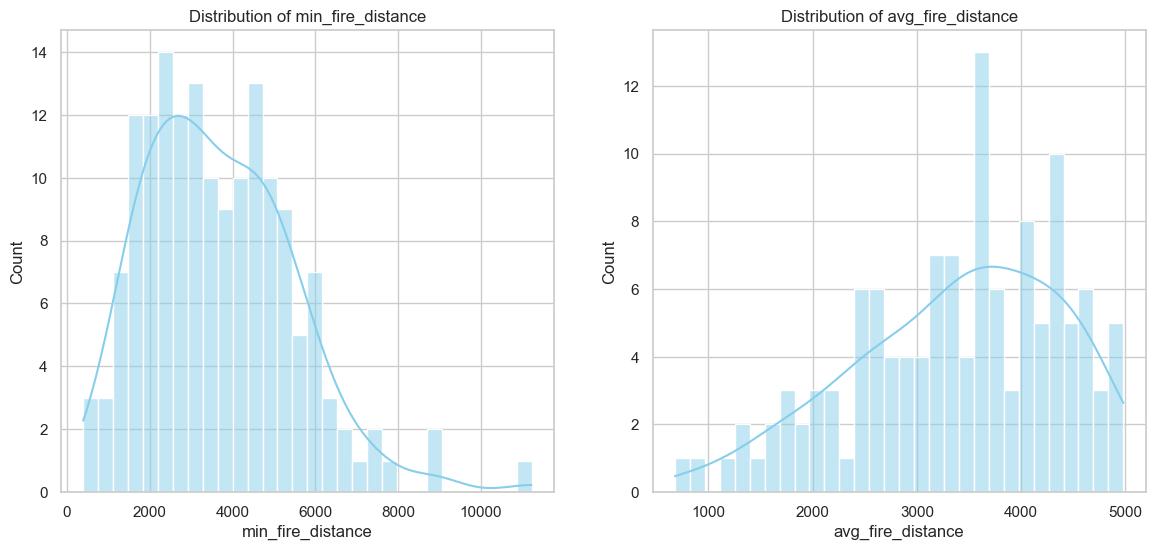

In [68]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# 첫 번째 subplot - min_fire_distance
plt.subplot(1, 2, 1)
sns.histplot(df_road_final['min_fire_distance'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of min_fire_distance')
plt.xlabel('min_fire_distance')
plt.ylabel('Count')

# 두 번째 subplot - avg_fire_distance
plt.subplot(1, 2, 2)
sns.histplot(df_road_final['avg_fire_distance'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of avg_fire_distance')
plt.xlabel('avg_fire_distance')
plt.ylabel('Count')

plt.show()

### 필요 요인 2. 산불 개수

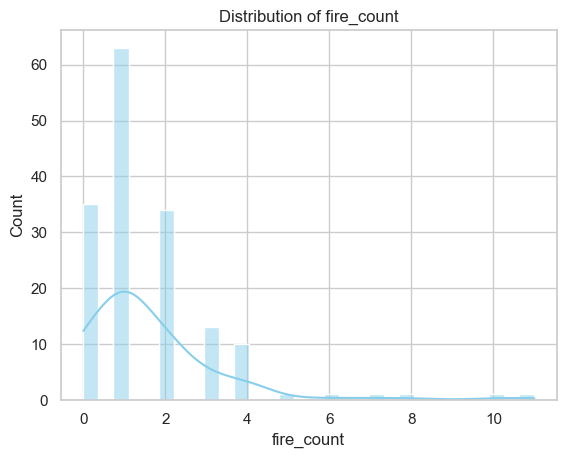

In [69]:
sns.histplot(df['fire_count'], kde=True, color='skyblue')
plt.title('Distribution of fire_count')

plt.show()

### 필요 요인 3. 임도 폭

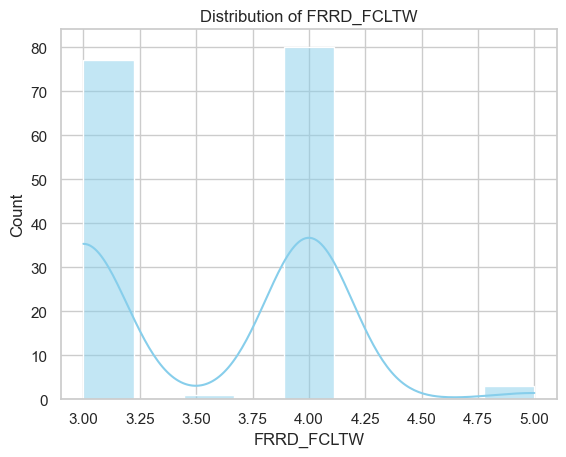

In [70]:
sns.histplot(df['FRRD_FCLTW'], kde=True, color='skyblue')
plt.title('Distribution of FRRD_FCLTW')

plt.show()

### 필요 요인 4. 인간에 의한 발화X 

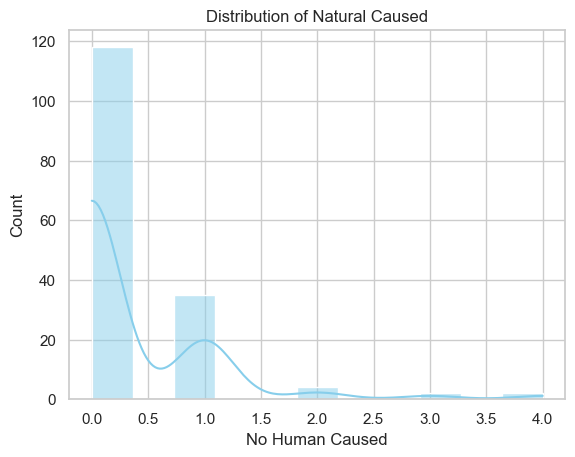

In [71]:
sns.histplot(df['No Human Caused'], kde=True, color='skyblue')
plt.title('Distribution of Natural Caused')

plt.show()

### 주의 요인 1. 고도 

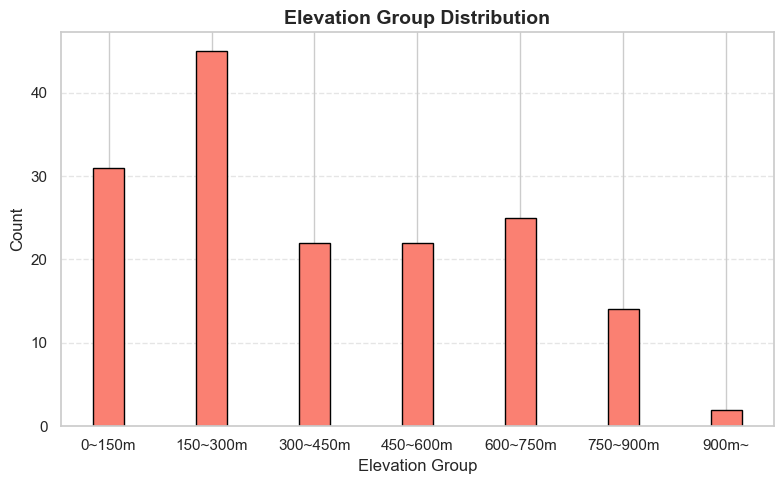

In [72]:
# elevation_group별 개수 세기
group_table = df["elevation_group"].value_counts().sort_index().reset_index()
group_table.columns = ["Elevation Group", "Count"]

# 막대그래프 그리기
plt.figure(figsize=(8, 5))
plt.bar(group_table["Elevation Group"], group_table["Count"],
        color="salmon", edgecolor="black", width=0.3)

plt.title("Elevation Group Distribution", fontsize=14, weight="bold")
plt.xlabel("Elevation Group")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 주의 요인 2. 경사도

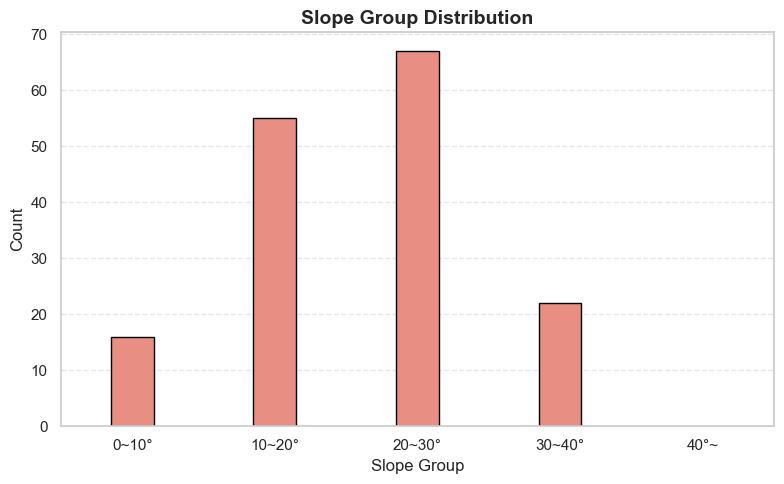

In [73]:
plt.figure(figsize=(8, 5))

# slope_group 기준으로 막대 그래프
sns.countplot(data=df_slope, x="slope_group",
              color="salmon", edgecolor="black", width=0.3)
plt.title("Slope Group Distribution", fontsize=14, weight="bold")
plt.xlabel("Slope Group")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 전체 점수 분포

In [74]:
# 주요 점수에 관련된 컬럼들만 선택
score_columns = [
    "min_fire_distance_norm",
    "avg_fire_distance_norm",
    "distance_score",
    "fire_count_score",
    "FRRD_FCLTW_score",
    "no_human_cause_score",
    "elevation_weight",
    "slope_weight"
]

# 수치형만 추출되도록 float로 변환 (category 타입 대응)
df_numeric = df[score_columns].apply(lambda col: col.astype(float) if col.dtypes.name == 'category' else col)

# 통계 요약 (평균, 편차, 최솟값, 최댓값)
stats_df = df_numeric.agg(['mean', 'std', 'min', 'max']).T
stats_df = stats_df.sort_values(by='std', ascending=False)

# 계산 결과 출력
pd.set_option('display.float_format', '{:.4f}'.format)
print(stats_df)

                         mean    std    min    max
FRRD_FCLTW_score       0.6373 0.3498 0.3000 1.0000
fire_count_score       0.3851 0.3149 0.0000 1.0000
elevation_weight       0.7161 0.2676 0.1000 1.0000
avg_fire_distance_norm 0.2898 0.2558 0.0000 1.0000
no_human_cause_score   0.1335 0.2485 0.0000 1.0000
slope_weight           0.6832 0.1711 0.4000 1.0000
min_fire_distance_norm 0.6967 0.1671 0.0000 1.0000
distance_score         0.0740 0.0305 0.0000 0.1480


In [75]:
# 시각화를 위해서  자료들 좌표 맞춤
df = df.set_crs(epsg=5186, allow_override=True)
gdf_road = gdf_road.set_crs(epsg=5186, allow_override=True)


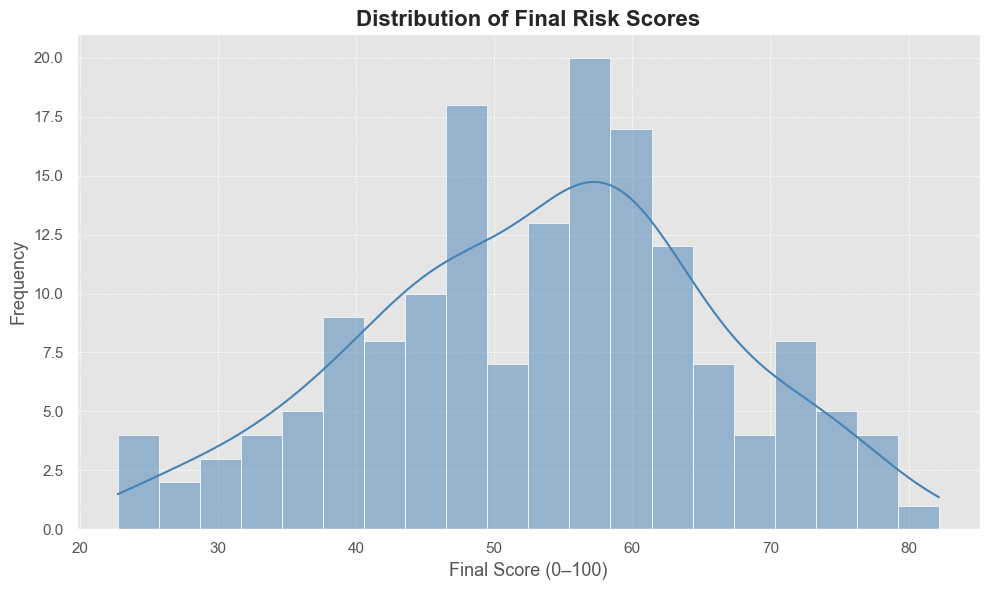

In [76]:
# 스타일 적용
plt.style.use("ggplot")

# 그래프 사이즈 설정
plt.figure(figsize=(10, 6))

# Seaborn을 이용한 히스토그램 + KDE 커브
sns.histplot(df['final_score'], bins=20, kde=True, color='steelblue', edgecolor='white')

# 타이틀 및 축 라벨
plt.title('Distribution of Final Risk Scores', fontsize=16, weight='bold')
plt.xlabel('Final Score (0–100)', fontsize=13)
plt.ylabel('Frequency', fontsize=13)

# 눈금 스타일
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)


# 격자선 설정
plt.grid(visible=True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


### 상위 하위 5% 임도 시각화

In [77]:
df = df.set_crs(epsg=5186, allow_override=True)
gdf_road = gdf_road.set_crs(epsg=5186, allow_override=True)


In [78]:
# 1) 좌표계가 제대로 지정되어 있는지 확인 (EPSG:5186)
print(gdf_road.crs)  

# 2) EPSG:5186 좌표계로 변환 (없으면 set_crs 후 to_crs)
#gdf_road = gdf_road.set_crs(epsg=4326, allow_override=True)  # 원본 좌표가 위도경도면 먼저 지정
gdf_road = gdf_road.set_crs(epsg=5186, allow_override=True)  # 원본 좌표가 위도경도면 먼저 지정
#gdf_road = gdf_road.to_crs(epsg=5186)

# 3) 중심점과 버퍼 재계산 (이때 좌표계가 맞음)
gdf_road['centroid'] = gdf_road.geometry.centroid
gdf_road['buffer'] = gdf_road['centroid'].buffer(5000)

EPSG:5186


In [79]:
# 4) 시각화 직전에 EPSG:3857로 변환
gdf_road = gdf_road.to_crs(epsg=3857)

# 4) 중심점, 버퍼도 EPSG:3857로 변환 (새로운 GeoSeries로)
gdf_road['centroid'] = gdf_road.geometry.centroid  # 다시 centroid 재계산 해도 됨
gdf_road['buffer'] = gdf_road['centroid'].buffer(5000)

In [80]:
print(gdf_road.crs)
print(gdf_road['centroid'].crs)  # centroid는 Series라 직접 안 나올 수도 있으니, 예를 들어 첫 점 좌표 확인
print(gdf_road['buffer'].crs)    # buffer도 마찬가지



EPSG:3857
EPSG:3857
EPSG:3857


In [81]:
# 0. 사전 준비: df 기준으로 점수/등급 추출
score_df = df[["임도ID", "final_score", "risk_grade"]].copy()

# 1. 병합 (gdf_road에 final_score, risk_grade 추가)
gdf_road = gdf_road.merge(score_df, on="임도ID", how="left")


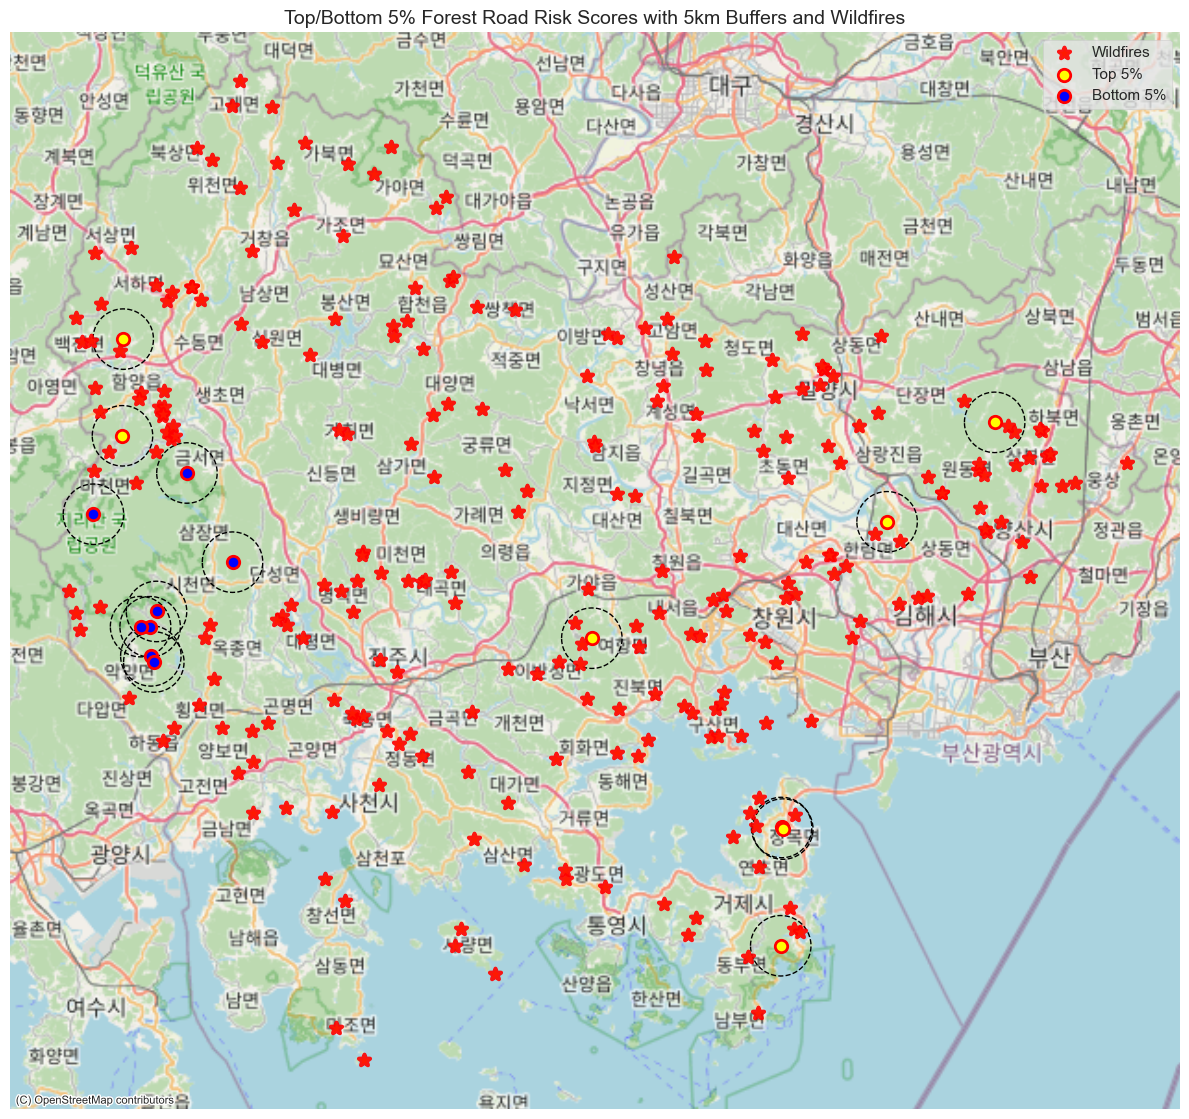

In [82]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import pandas as pd

# 좌표계 통일
gdf_road = gdf_road.to_crs(epsg=3857)
gdf_fire = gdf_fire.to_crs(epsg=3857)

# 임도 중심점 계산
gdf_road["centroid"] = gdf_road.geometry.centroid

# 중심점 GDF 생성
gdf_center = gpd.GeoDataFrame(
    gdf_road[["임도ID", "final_score", "risk_grade"]].copy(),
    geometry=gdf_road["centroid"],
    crs=gdf_road.crs
)

# 상위 5개 + 하위 5개만 선택
top5 = gdf_center.sort_values(by="final_score", ascending=False).head(8)
bottom5 = gdf_center.sort_values(by="final_score", ascending=True).head(8)
gdf_selected = pd.concat([top5, bottom5])

# 각 임도 반경 5km 원 생성
gdf_selected["buffer"] = gdf_selected.geometry.buffer(5000)

# 시각화
fig, ax = plt.subplots(figsize=(12, 12))

# 5km 원
gdf_selected.set_geometry("buffer").plot(ax=ax, color="none", edgecolor="black", linestyle="--", linewidth=1)

# 산불 지점 표시
gdf_fire.plot(
    ax=ax,
    markersize=70,
    color="yellow",
    edgecolor="red",
    marker="*",
    linewidth=3.0,
    alpha=0.9,
    label="Wildfires"
)

# 중심점
top5.plot(ax=ax, color="yellow", markersize=80,# marker="*",
          edgecolor="red", linewidth=2.0, label="Top 5%")
bottom5.plot(ax=ax, color="blue", markersize=80,# marker="*",
             edgecolor="red", linewidth=2.0, label="Bottom 5%")

# 배경지도 시각화
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=gdf_selected.crs.to_string())

# 제목 설정
ax.set_title("Top/Bottom 5% Forest Road Risk Scores with 5km Buffers and Wildfires", fontsize=14)
ax.axis("off")
ax.legend()

plt.tight_layout()
plt.show()
